# y-Aware on OpenBHB with NIDL

This notebook will show you how to use a y-Aware models on OpenBHB dataset. It can be used as brain age model or as latent-based model of normal brain aging. 

## Install and load the packages

First, we need to install some Python packages used by NIDL (if not already done):

In [ ]:
%pip install -e ../

In [1]:
from nilearn import plotting, datasets
import nibabel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# This library
from nidl.datasets.openbhb import OpenBHB
from nidl.models import yAware
from nidl.data.collate import TwoViewsCollateFunction
from nidl.interpretability import HaufeTransformation, SensitivityAnalysis
from nidl.transform import Transform

## Load the OpenBHB data and plot the modalities

OpenBHB [1] contains 6 modalities (or preprocessed data) of healthy subject anatomical brains. It contains $n_{train}=3227$ training images for $n_{val}=757$ validation images. Demographic information about the subjects (age, sex) are available along with the acquisition machines (magnetic field strenght, acquisition setting). 

[1] [OpenBHB: a Large-Scale Multi-Site Brain MRI Data-set for Age Prediction and Debiasing, Dufumier et al., NeuroImage 2022](https://www.sciencedirect.com/science/article/pii/S1053811922007522)

In [2]:
dataset = OpenBHB("/neurospin/signatures/bd261576/openBHB", target="age", 
                  modality=("vbm", "quasiraw", "vbm_roi", 
                            "fs_desikan_roi", "fs_destrieux_roi", 
                            "fs_xhemi"))

### Plot whole-brain VBM and Quasi-Raw image

(121, 145, 121)


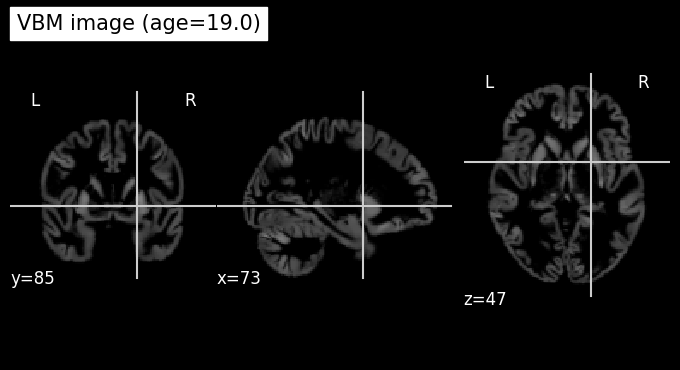

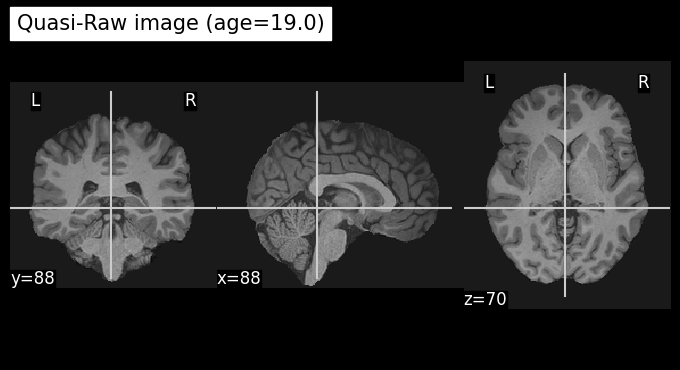

In [3]:
all_mods, age = dataset[0] # Subject 0

# VBM 
img_vbm = all_mods["vbm"][0] # select the first (and only) channel
nii_img = nibabel.Nifti1Image(img_vbm, affine=np.eye(4))
print(img_vbm.shape)
plotting.plot_anat(nii_img, title=f"VBM image (age={age})")

# Quasi-Raw
img_quasiraw = all_mods["quasiraw"][0] # select the first (and only) channel
nii_img = nibabel.Nifti1Image(img_quasiraw, affine=np.eye(4))
plotting.plot_anat(nii_img, title=f"Quasi-Raw image (age={age})")

### Plot VBM measures on Neuromorphometric atlas

Whole-brain gray matter volumes (VBM) are averaged by anatomical areas defined in the Neuromorphometric atlas (142 regions). 

In [4]:
def map_vbm_neuromorphometric_data(roi_values, labels, atlas):
    # Map ROI values to the Neuromorphometric template
    atlas_data = atlas["data"].get_fdata()
    atlas_labels = atlas["labels"]
    brain_map = np.zeros_like(atlas_data)
    idx_mapping = {name: atlas_labels.index(name) for name in labels}
    for idx, label in enumerate(labels):
        brain_map[atlas_data == idx_mapping[label]] = roi_values[idx]
    brain_map = nibabel.Nifti1Image(brain_map, affine=atlas["data"].affine)
    return brain_map


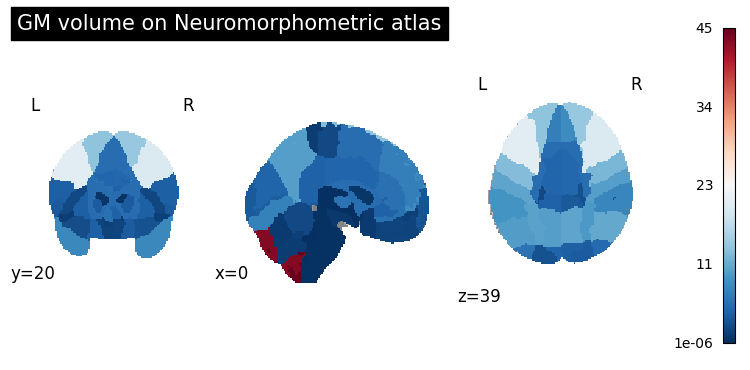

In [6]:
# VBM-ROI 
vbm_roi = all_mods["vbm_roi"][0][:142] # select the first 142 regions (GM volume)
atlas = dataset.get_neuromorphometric_atlas()
labels = dataset.get_vbm_roi_labels()[:142]
brain_map = map_vbm_neuromorphometric_data(vbm_roi, labels, atlas)
plotting.plot_stat_map(brain_map, title="GM volume on Neuromorphometric atlas", cmap='RdBu_r', draw_cross=False)

### Plot surface-based measurements 

Surface-based measures given by FreeSurfer (cortical thickness, surface area, GM volume, curvature) are averaged for each area defined in the Desikan (34 regions per hemisphere) and Detrieux atlas (74 regions per hemisphere, excluding the medial wall). 

Let's define a small utility function for mapping the ROI measurements on the default FreeSurfer template (fsaverage5).

In [7]:
def map_freesurfer_destrieux_data(roi_values, labels, hemi="left"):
    # Load Destrieux atlas 
    fsaverage = datasets.fetch_atlas_surf_destrieux()
    fs_labels = [l.decode("utf-8") for l in fsaverage['labels']]
    map_hemi = fsaverage[f'map_{hemi}']
    
    # Map ROI values to vertex-wise data using the labels 
    idx_mapping = {name: fs_labels.index(name) for name in labels}
    vertex_data = np.zeros_like(map_hemi, dtype=float)

    for idx, roi_name in enumerate(labels):
        vertex_data[map_hemi == idx_mapping[roi_name]] = roi_values[idx]

    return vertex_data


#### Example 1: FreeSurfer surface area, GM volume and cortical thickness on Destrieux atlas

[get_dataset_dir] Dataset found in /home/bd261576/nilearn_data/destrieux_surface

[get_dataset_dir] Dataset found in /home/bd261576/nilearn_data/destrieux_surface

[get_dataset_dir] Dataset found in /home/bd261576/nilearn_data/destrieux_surface

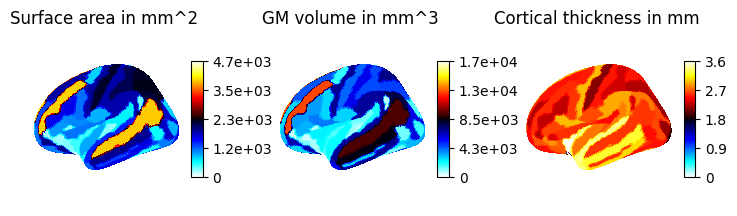

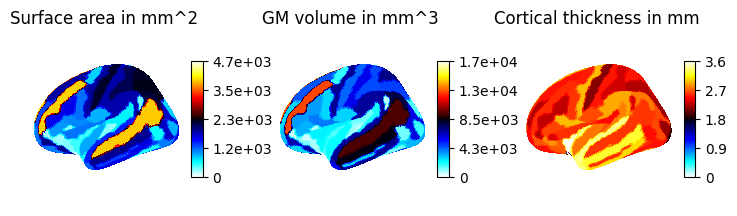

In [8]:
surface_area = dataset.get_freesurfer_channels()["surface_area_mm^2"]
volume = dataset.get_freesurfer_channels()["gray_matter_volume_mm^3"]
thickness = dataset.get_freesurfer_channels()["average_thickness_mm"]

labels = dataset.get_freesurfer_destrieux_labels(symmetric=True)
fs_surface = all_mods["fs_destrieux_roi"][surface_area]
fs_volume =  all_mods["fs_destrieux_roi"][volume]
fs_thickness =  all_mods["fs_destrieux_roi"][thickness]

surface_vertex = map_freesurfer_destrieux_data(fs_surface, labels)
volume_vertex = map_freesurfer_destrieux_data(fs_volume, labels)
thickness_vertex = map_freesurfer_destrieux_data(fs_thickness, labels)

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")

fig, axes = plt.subplots(1, 3, figsize=(9, 3), subplot_kw={'projection': '3d'})

plotting.plot_surf_stat_map(
    fsaverage['infl_left'], stat_map=surface_vertex,
    hemi='left', view='lateral', colorbar=True, 
    figure=fig, axes=axes[0],
    title="Surface area in mm^2", 
)
plotting.plot_surf_stat_map(
    fsaverage['infl_left'], stat_map=volume_vertex,
    hemi='left', view='lateral', colorbar=True, 
    figure=fig, axes=axes[1],
    title="GM volume in mm^3", 
)
plotting.plot_surf_stat_map(
    fsaverage['infl_left'], stat_map=thickness_vertex,
    hemi='left', view='lateral', colorbar=True,
    figure=fig, axes=axes[2],
    title="Cortical thickness in mm", 
)

#### Example 2: FreeSurfer cortical thickness and curvature on fsaverage7 template

Data in "xhemi" are already computed on the "fsaverage7" template (including 163842 vertices) so no mapping is required.

[get_dataset_dir] Dataset found in /home/bd261576/nilearn_data/fsaverage

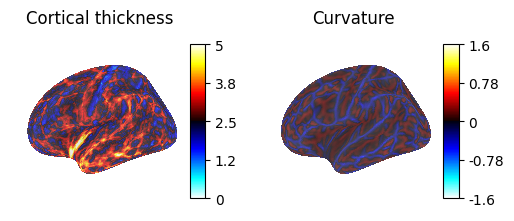

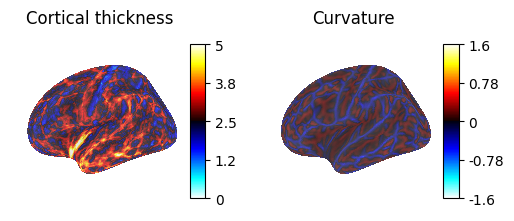

In [9]:
# Plot cortical thickness + curvature
thickness = dataset.get_freesurfer_xhemi_channels()["lh.thickness.mgz"]
curv = dataset.get_freesurfer_xhemi_channels()["lh.curv.mgz"]
fs_thickness = all_mods["fs_xhemi"][thickness]
fs_curv = all_mods["fs_xhemi"][curv]
fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage7")

fig, axes = plt.subplots(1, 2, figsize=(6, 4), subplot_kw={'projection': '3d'})

plotting.plot_surf_stat_map(
    fsaverage["infl_left"], stat_map=fs_thickness,
    hemi='left', 
    bg_map=fsaverage["sulc_left"],
    bg_on_data=True, darkness=.5, colorbar=True, 
    axes=axes[0],
    title="Cortical thickness")

plotting.plot_surf_stat_map(
    fsaverage["infl_left"], stat_map=fs_curv,
    hemi='left', 
    bg_map=fsaverage["sulc_left"],
    bg_on_data=True, darkness=.5, colorbar=True, 
    axes=axes[1],
    title="Curvature")


## Fit yAware using age as auxiliary variable

For efficiency, we will fit y-Aware on VBM-ROI modality using age as auxiliary variable. We will then plot the latent space and compare with y-Aware fit on FreeSurfer Destrieux-ROI modality. 

### Build scorer for age

Since NeuroCLAV is an embedding model and we don't know the true latent factors of the data, we use a KNN regression to test whether age is decodable from the embedding. 

In [10]:
def prediction_score(z, y):
    def _knn_fitting(x, y):
        knn_model = KNeighborsRegressor()
        knn_model.fit(x, y)
        return knn_model.score(x, y), knn_model.predict(x)
    return _knn_fitting(z, y)

### Load VBM-ROI modality and fit the models

In [26]:
# Load the data
dataset_train = OpenBHB("/neurospin/signatures/bd261576/openBHB", target="age", modality="vbm_roi", split="train")
dataset_test_wo_labels = OpenBHB("/neurospin/signatures/bd261576/openBHB", target=None, 
                                 modality="vbm_roi", split="val")
dataset_test = OpenBHB("/neurospin/signatures/bd261576/openBHB", target="age", 
                                 modality="vbm_roi", split="val")
train_dataloader = DataLoader(dataset_train, batch_size=128, num_workers=10,
                              shuffle=True, collate_fn=TwoViewsCollateFunction())
val_dataloader = DataLoader(dataset_test, batch_size=128, num_workers=10,
                            shuffle=True, collate_fn=TwoViewsCollateFunction())
test_dataloader_wo_labels = DataLoader(dataset_test_wo_labels, batch_size=128, num_workers=10, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=128, num_workers=10, shuffle=False)

In [27]:
# Fit y-Aware (without data augmentation)
yaware = yAware(
    encoder="mlp",
    encoder_kwargs={"layers": [284, 128, 128]},
    n_embedding=16,
    max_epochs=20
)
yaware.fit(train_dataloader, val_dataloader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | encoder_         | MLP                  | 55.6 K | train
1 | projection_head_ | yAwareProjectionHead | 74.4 K | train
2 | loss_            | yAwareInfoNCE        | 0      | train
------------------------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.520     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home_local/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 174.01it/s]Bandwidth automatically set to:
 [[15.52414532]]


/home_local/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 26/26 [00:23<00:00,  1.09it/s, v_num=17, loss/train=6.900]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:24<00:00,  1.08it/s, v_num=17, loss/train=6.900]


yAware(
  (encoder_): MLP(
    (mlp): Sequential(
      (0): BasicBlock(
        (linear): Linear(in_features=284, out_features=128, bias=True)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): BasicBlock(
        (linear): Linear(in_features=128, out_features=128, bias=True)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (projection_head_): yAwareProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (loss_): yAwareInfoNCE(
    (sim_metric): PairwiseCosineSimilarity()
  )
)

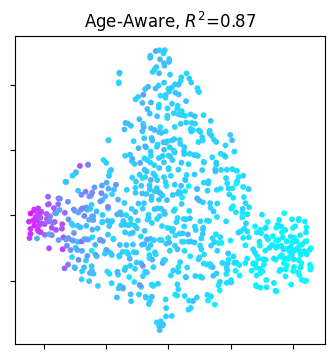

In [28]:
fig, axis = plt.subplots(1, 1, figsize=(4, 4), squeeze=False)
for i, (model, model_name) in enumerate([[yaware, "Age-Aware"]]):
    embedding = model.transform(test_dataloader_wo_labels)
    y_test = [s[1] for s in dataset_test.samples]
    score, y_pred = prediction_score(embedding, y_test)
    embedding_2d = TSNE(n_components=2).fit_transform(embedding)
    sc = axis[0, i].scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y_test, s=10, cmap="cool")
    axis[0, i].set_title(f"{model_name}, $R^2$={score:.2f}")
    axis[0, i].set_xticklabels([]); axis[0, i].set_yticklabels([])
    if i == 1:
        fig.colorbar(sc, ax=axis[0, i], label='Age')
plt.show()

Text(0.5, 0.98, 'Predicted Brain Age vs Chronological Age')

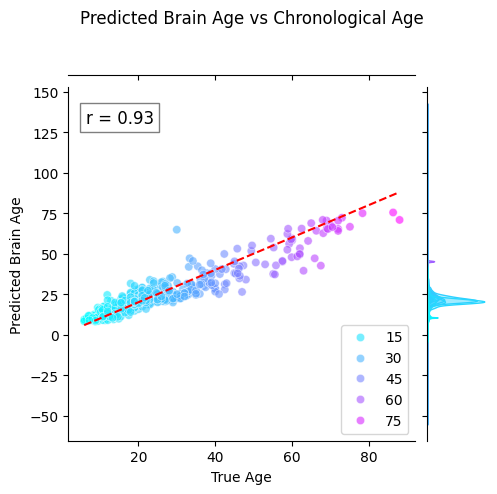

In [29]:
df = pd.DataFrame({"True age": y_test, "Predicted brain age": y_pred})
r_value, _ = pearsonr(y_test, y_pred)
# Create the joint plot with KDE histograms
g = seaborn.jointplot(
    data=df, x="True age", y="Predicted brain age", 
    hue="True age", kind="scatter", alpha=0.6,
    marginal_kws={'fill': True},  # Filled histograms
    palette="cool", height=5
)
g.ax_joint.text(0.05, 0.9, f"r = {r_value:.2f}", transform=g.ax_joint.transAxes, 
                fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# Reference line y = x
min_age, max_age = np.min(y_test), np.max(y_test)
g.ax_joint.plot([min_age, max_age], [min_age, max_age], 'r--')
g.ax_joint.legend()
g.ax_joint.set_xlabel("True Age")
g.ax_joint.set_ylabel("Predicted Brain Age")
g.figure.suptitle("Predicted Brain Age vs Chronological Age")

### Fitting quality according to number of latent dimensions

We evaluate the fitting quality of NeuroCLAV to the data thanks to Kruskal stress and residual variance score.

### Load OpenBHB-MultiModal across VBM and SBM modalities

We will fit NeuroCLAV on both volume-based and surface-based measurements (here cortical thickness) and check its representation.

In [9]:
# Custom transformation to handle multimodal OpenBHB dataset
class ConcatModalities(Transform):
    def __init__(self, modalities,  channels=None, **kwargs):
        super().__init__(**kwargs)
        self.modalities = modalities # Define modalities order
        self.channels = channels # Select only one channel per modality

    def apply_transform(self, data):
        if self.channels is not None:
            output = np.concat([data[k][c] for (k, c) in zip(self.modalities, self.channels)], axis=-1)
        else:
            output = np.concat([data[k].flatten() for k in self.modalities], axis=-1)
        return output

In [ ]:
modalities = ("vbm_roi", "fs_destrieux_roi")
thickness = dataset.get_freesurfer_channels()["average_thickness_mm"]
channels = (0, thickness)
dataset_train_mm = OpenBHB("/neurospin/hc/openBHB", target="age", 
                           modality=modalities, split="train",
                           transforms=ConcatModalities(modalities, channels))
dataset_test_mm = OpenBHB("/neurospin/hc/openBHB", target="age", 
                          modality=modalities, split="val",
                          transforms=ConcatModalities(modalities, channels))
dataloader_train_mm = DataLoader(
    dataset_train_mm, batch_size=128, num_workers=10,
    shuffle=True, collate_fn=TwoViewsCollateFunction())
dataloader_test_mm = DataLoader(
    dataset_test_mm, batch_size=128, num_workers=10, shuffle=False)

### Fit y-Aware model

In [ ]:
yaware_mm = yAware(
    encoder="mlp",
    encoder_kwargs={"layers": [432, 128, 128]},
    n_embedding=16
)
yaware_mm.fit(dataloader_train_mm)

(np.float64(-47.701557350158694),
 np.float64(59.59292621612549),
 np.float64(-30.724140930175782),
 np.float64(25.639881896972657))

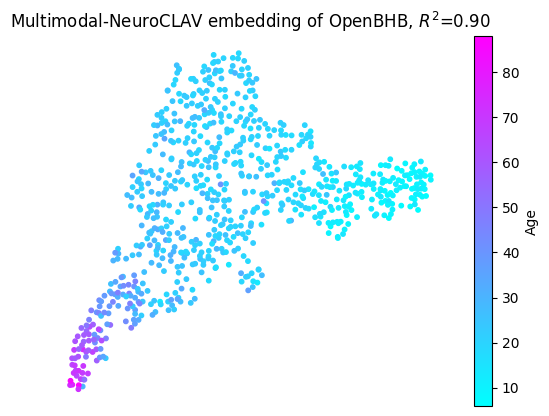

In [ ]:
embedding_mm = yaware_mm.transform(dataloader_test_mm)
y_test = [s[1] for s in dataset_test_mm.samples]
yaware_mm_score, y_pred = prediction_score(embedding_mm, y_test)
embedding_2d_mm = TSNE(n_components=2).fit_transform(embedding_mm)
plt.scatter(embedding_2d_mm[:, 0], embedding_2d_mm[:, 1], c=y_test, s=10, cmap="cool")
cbar = plt.colorbar(label='Age')
plt.title(f"Multimodal-NeuroCLAV embedding of OpenBHB, $R^2$={yaware_mm_score:.2f}")
plt.axis("off")

## Interpretability of y-Aware with sensitivity analysis and forward maps

For simplicity, we will demonstrate how to obtain maps of **features importance for age prediction**. Similar logic can be followed to study other problems, e.g. classification of patients vs. controls. 

First, we define a model that combine NeuroCLAV with a linear model trained on top.

In [17]:
class CombinedModel(torch.nn.Module):
    def __init__(self, embedding_model: torch.nn.Module, linear_model: LinearRegression):
        super().__init__()
        self.embedding_model = embedding_model  # Pretrained torch model
        weight = torch.tensor(linear_model.coef_, dtype=torch.float32)
        bias = torch.tensor(linear_model.intercept_, dtype=torch.float32)
        if weight.ndim == 2:
            self.linear = torch.nn.Linear(weight.shape[1], weight.shape[0])
        else:
            self.linear = torch.nn.Linear(weight.shape[0], 1)
            
        # Set weights & bias from scikit-learn
        with torch.no_grad():
            self.linear.weight.copy_(weight)
            self.linear.bias.copy_(bias)
    
    def forward(self, x):
        embeddings = self.embedding_model(x) 
        output = self.linear(embeddings) 
        return output

In [ ]:
linear_model = LinearRegression()
linear_model.fit(embedding, y_test)
combined_model = CombinedModel(yaware.encoder_, linear_model)

### Sensitivity analysis

We first plot the map $M_i:=\left(\frac{\partial f(x_i)}{\partial x_{i,j}}\right)_{j\in [1..p]}$ to study how input features $(x_{i,j})_{i, j\in [1..n]\times [1..p]}$ impact the prediction $f(x_i)$ for each sample $i\in [1..n]$.

The maps $(M_i)_{i\in [1..n]}$ can be averaged to see the global features importance.

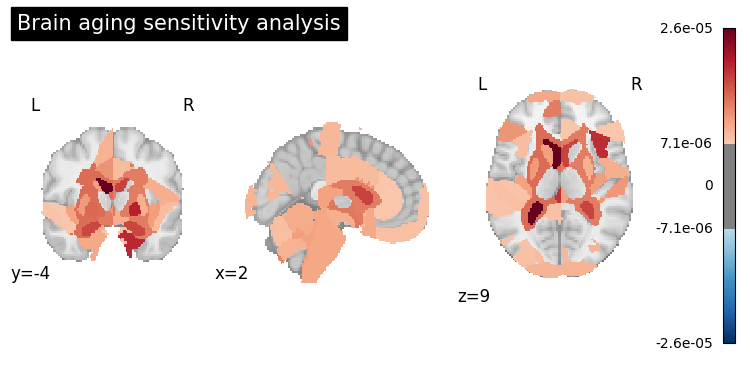

In [ ]:
# Compute activation heatmaps for each input
heatmaps_sens = SensitivityAnalysis(combined_model)(test_dataloader)

# Map the average heatmap on the brain atlas
atlas = dataset.get_neuromorphometric_atlas()
labels = dataset.get_vbm_roi_labels()[:142]
heatmap_map = map_vbm_neuromorphometric_data(np.mean(heatmaps_sens, axis=0)[0, :142], labels, atlas)
threshold = np.percentile(np.abs(heatmap_map.get_fdata()), 90)
plotting.plot_stat_map(heatmap_map, title="Brain aging sensitivity analysis",
                    cmap='RdBu_r', threshold=threshold, symmetric_cbar=True, 
                    draw_cross=False)

### Forward maps

Then, we use the Haufe transformation [1] to derive a "forward" map $M=\text{Cov}(X, f(X))\in \mathbb{R}^{p}$, the covariance between input $X=(x_i)_{i\in[1..n]}\in \mathbb{R}^{n\times p}$ and predicted output $f(X):=(f(x_i))_{i\in [1..n]}\in \mathbb{R}^{n}$.

[1] On the interpretation of weight vectors of linear models in multivariate neuroimaging, Haufe et al., NeuroImage 2014

In [ ]:
# Compute activation heatmap across the dataset
heatmaps_ht = HaufeTransformation(combined_model)(test_dataloader)

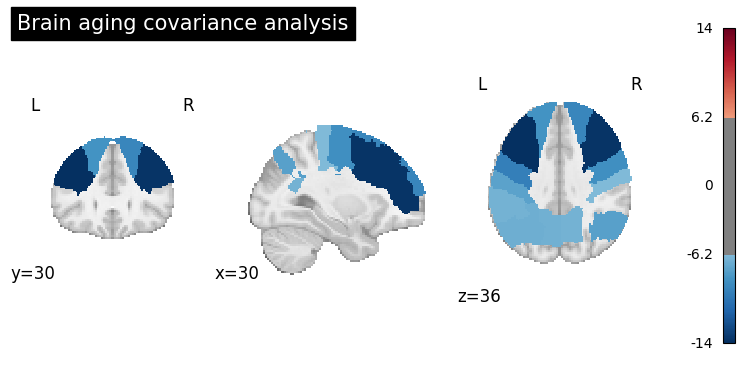

In [31]:
# Plot the heatmap
atlas = dataset.get_neuromorphometric_atlas()
labels = dataset.get_vbm_roi_labels()[:142]
heatmap_map = map_vbm_neuromorphometric_data(heatmaps_ht[0, :142], labels, atlas)
threshold = np.percentile(np.abs(heatmap_map.get_fdata()), 90)
plotting.plot_stat_map(heatmap_map, title="Brain aging covariance analysis",
                    cmap='RdBu_r', threshold=threshold, symmetric_cbar=True, 
                    draw_cross=False)